In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import OneHotEncoder
import importlib


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *

In [52]:
import auxFuns.modelling 
importlib.reload(auxFuns.modelling )

<module 'auxFuns.modelling' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\modelling.py'>

# 1. Exploration of ML algorithms and visualization of their decision boundaries
- Fitting various ML algorithms (linear, tree-based, distance-based)
- Interpretability and explanation

In [4]:
# Load data sets under study (VSCode)
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_phase1_df = pd.read_csv(raw_datasets_path + '/rsv_predictors_df_phase1_v3.csv')
rsv_predictors_phase1_daysDedup_df = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup.csv',low_memory=False)

# Load data sets under study (GColab)
# rsv_predictors_phase1_df = pd.read_csv('/content/rsv_predictors_df_phase1_v3.csv')
# rsv_predictors_phase1_daysDedup_df = pd.read_csv('/content/rsv_predictors_phase1_daysDedup.csv', low_memory=False)

In [7]:
rsv_predictors_phase1_df = make_it_categorical(rsv_predictors_phase1_df)
rsv_predictors_phase1_daysDedup_df = make_it_categorical(rsv_predictors_phase1_daysDedup_df)

rsv_predictors_phase1_df.shape, rsv_predictors_phase1_daysDedup_df.shape

# Extract a reduced sample of the data for modelling
sample_size = 20000
sample_rsv_df = rsv_predictors_phase1_df.sample(n = sample_size)
sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.sample(n = sample_size)

# sample_rsv_df = rsv_predictors_phase1_df.copy()
# sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.copy()

In [8]:
sample_rsv_df['RSV_test_result'].value_counts(), sample_dedup_rsv_df['RSV_test_result'].value_counts()

(RSV_test_result
 Negative    19392
 Positive      608
 Name: count, dtype: int64,
 RSV_test_result
 Negative    19425
 Positive      575
 Name: count, dtype: int64)

In [54]:
# 1. Transform the data and prepare it for modelling
df1 = sample_rsv_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters'], axis = 1)

X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_rsv(df1, 
                                                                          input_test_size = 0.2, random_seed = 42
                                                                          )

In [55]:
# 2. Fit the model, specyfing a) model class b) hyperparameter_grid, target_scorer, number of cross-validation folds
model_class = RandomForestClassifier()
param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, average='macro')
n_cv_folds = 10

model1 = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train)


Training model ... RandomForestClassifier()
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 14}
Best training f1-score:  0.6114666616578158


AUC Score: 0.7434851479596843
Precision / Positive predictive value: 0.7391304347826086
Specificity: 0.998450012916559
Recall / sensitivity: 0.13178294573643412
Negative predictive value: 0.9718380688961529
Accuracy: 0.9705
F-1: 0.2236842105263158


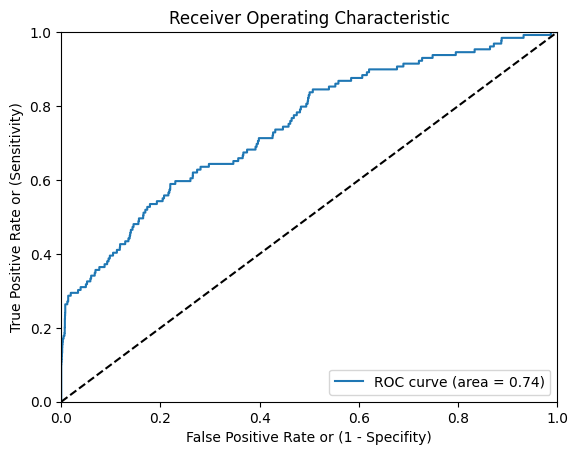

In [56]:
# 3. Evaluate the model

__,__,__,__,__,__,f1_score = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test, print_roc = True)

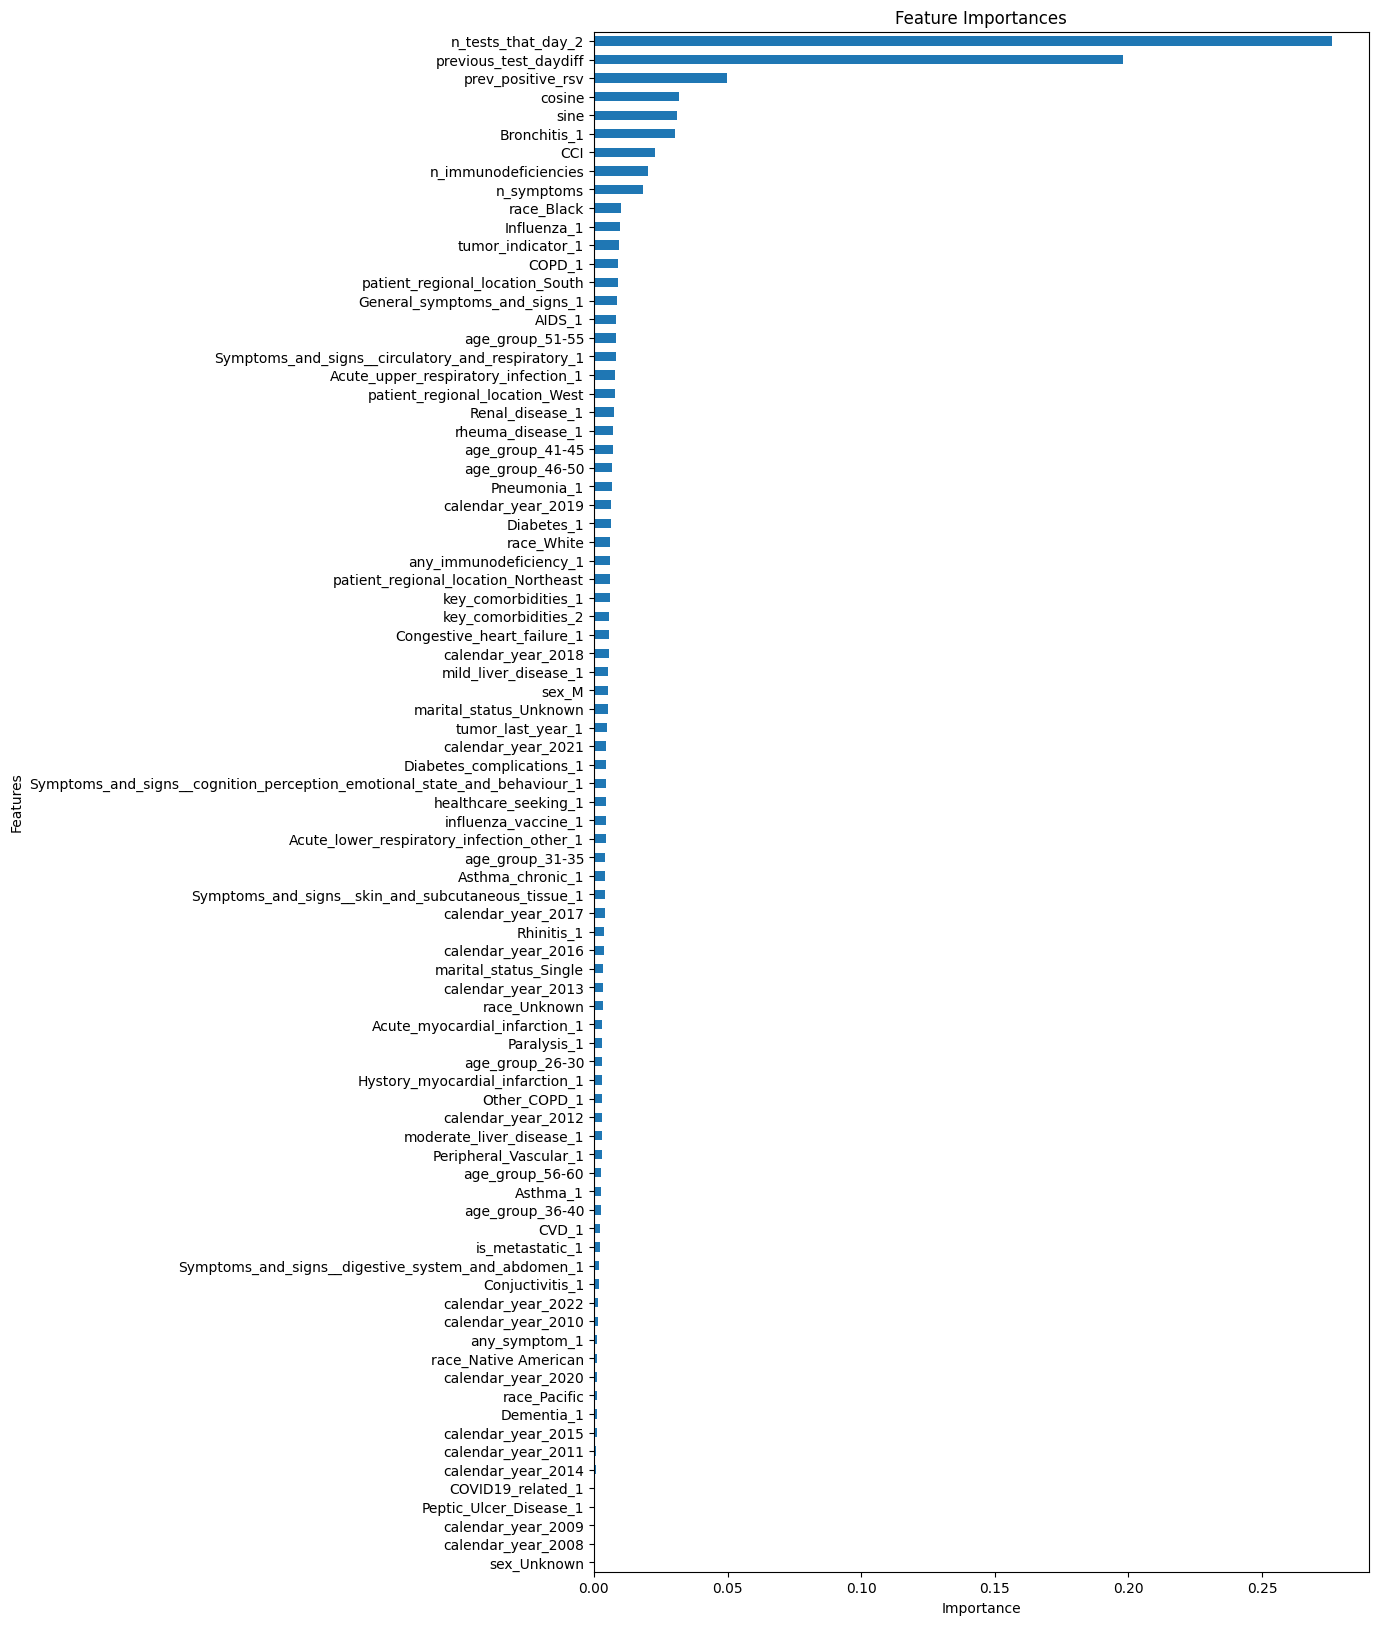

In [57]:
# Observe the feature importances plot to detect potential inconsistencies
plot_feature_importance_rf_rsv(preprocessor_rsv, trained_model = model1)